In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from spcqe.quantiles import SmoothPeriodicQuantiles
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import get_pvdaq_data

### Load data table from external source

For today's example, we're loading data from NREL's PVDAQ API, which is a publically available PV generatation data set. 

In [4]:
data_frame = get_pvdaq_data(sysid=34, year=range(2011, 2015), api_key='DEMO_KEY')

[============================================================] 100.0% ...queries complete in 7.0 seconds       



In [5]:
data_frame.head()

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
2011-01-01 00:00:00,34.0,0.0,-200.0,284.0,-3.353332,0.0,-200.0,16.0,0.0,37.0,-7.105555,0.0,0.0,53.513,315.270,0.483250
2011-01-01 00:15:00,34.0,0.0,-300.0,284.0,-3.381110,0.0,-200.0,16.0,0.0,36.0,-6.944444,0.0,0.0,53.581,308.835,0.698724
2011-01-01 00:30:00,34.0,0.0,-300.0,284.0,-3.257777,0.0,-200.0,16.0,0.0,36.0,-6.344444,0.0,0.0,53.413,272.678,0.218156
2011-01-01 00:45:00,34.0,0.0,-200.0,283.0,-3.296666,0.0,0.0,15.0,0.0,36.0,-6.655555,0.0,0.0,52.406,55.913,0.159146
2011-01-01 01:00:00,34.0,0.0,-300.0,284.0,-3.426110,0.0,-200.0,14.0,0.0,35.0,-7.405555,0.0,0.0,53.588,152.145,0.240508


### Running the `DataHandler` processing pipeline

In [6]:
dh = DataHandler(data_frame)

In [7]:
dh.run_pipeline(power_col='ac_power', solver='MOSEK')

total time: 2.03 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.28s
Cleaning                   0.07s
Filtering/Summarizing      0.68s
    Data quality           0.06s
    Clear day detect       0.11s
    Clipping detect        0.09s
    Capacity change detect 0.41s



In [8]:
dh.report()


-----------------
DATA SET REPORT
-----------------
length               4.00 years
capacity estimate    107.10 kW
data sampling        15 minutes
quality score        0.96
clearness score      0.55
inverter clipping    False
clipped fraction     0.00
capacity changes     False
data quality warning True
time shift errors    False
time zone errors     False
            


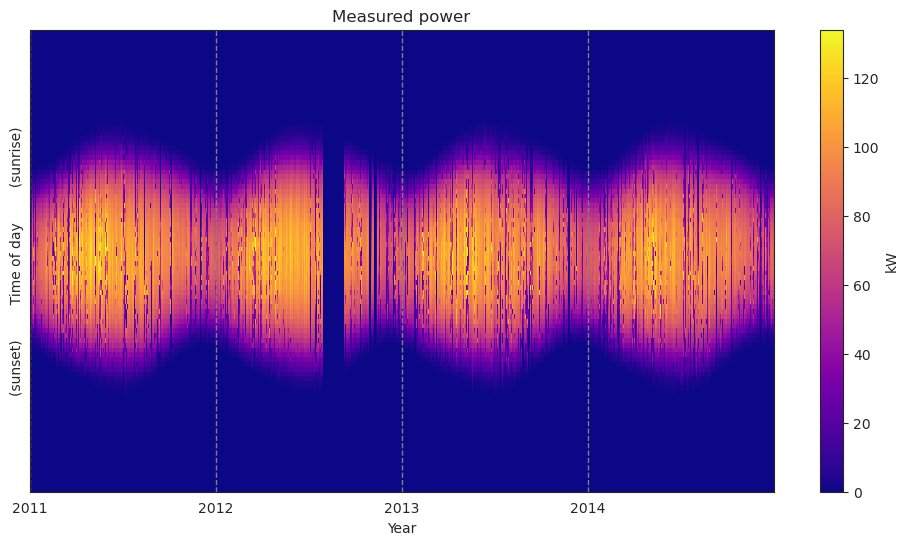

In [9]:
dh.plot_heatmap('filled');

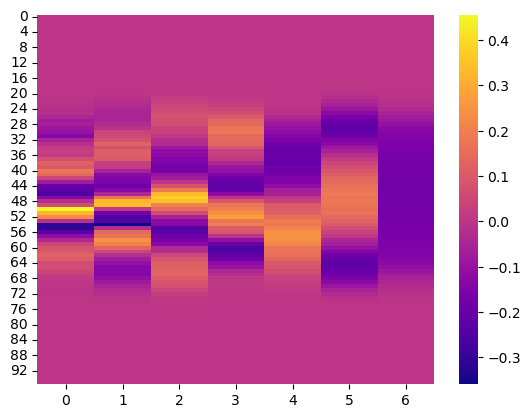

In [10]:
D = dh.filled_data_matrix.copy()
D_max = np.max(D)
mu = np.average(D/D_max, axis=1)
D_tilde = (D.T/D_max - mu).T
u, d = np.linalg.eigh(D_tilde @ D_tilde.T)
basis_unit = d[:,-7:]
sns.heatmap(basis_unit, cmap='plasma');

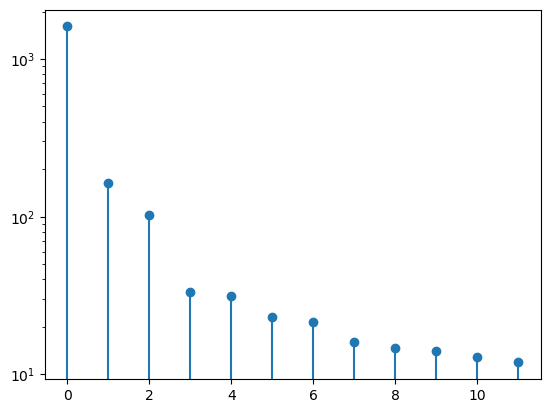

In [27]:
plt.stem(-np.sort(-u)[:12])
plt.yscale('log');

In [11]:
smoothed_basis = cvx.Variable(basis_unit.shape)
loss = smoothed_basis - basis_unit
cost = cvx.sum_squares(loss) + 1e1 * cvx.sum_squares(cvx.diff(smoothed_basis, k=2, axis=0))
problem = cvx.Problem(cvx.Minimize(cost))
problem.solve(solver='CLARABEL');

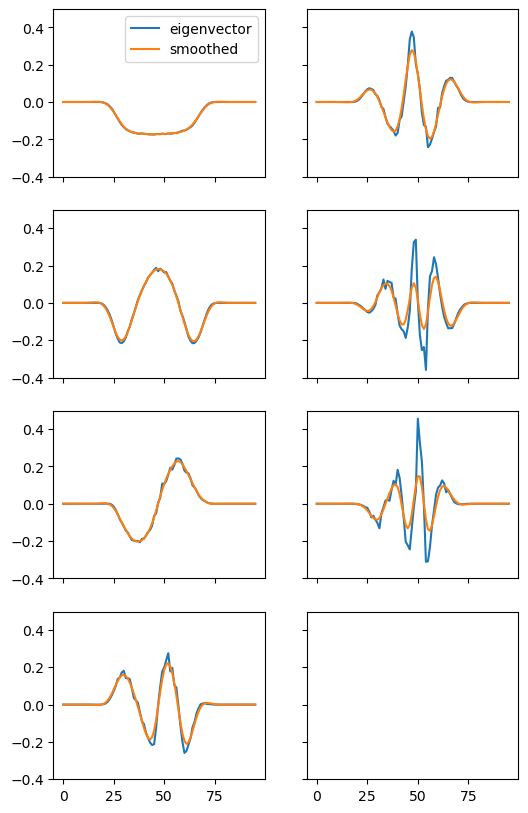

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for ix in range(7):
    i = ix % 4
    j = ix // 4
    ax[i,j].plot(basis_unit[:, -(ix+1)], label='eigenvector')
    ax[i,j].plot(smoothed_basis.value[:, -(ix+1)], label="smoothed")
ax[0,0].legend()

In [21]:
Q, R = np.linalg.qr(smoothed_basis.value)

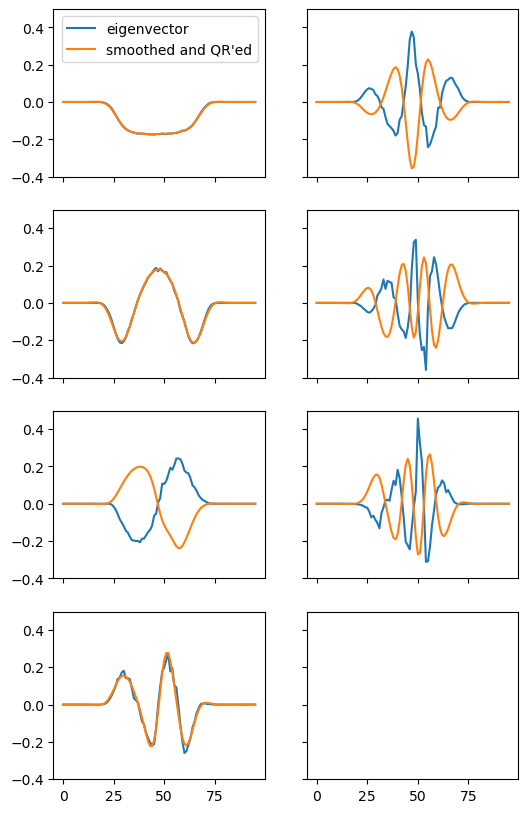

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for ix in range(7):
    i = ix % 4
    j = ix // 4
    ax[i,j].plot(basis_unit[:, -(ix+1)], label='eigenvector')
    ax[i,j].plot(Q[:, -(ix+1)], label="smoothed and QR'ed")
ax[0,0].legend()

<Axes: >

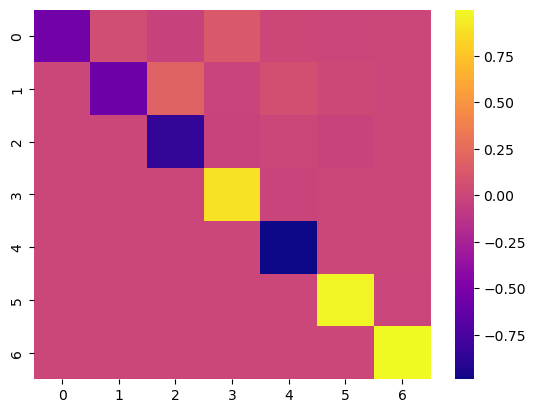

In [64]:
sns.heatmap(R, cmap='plasma')

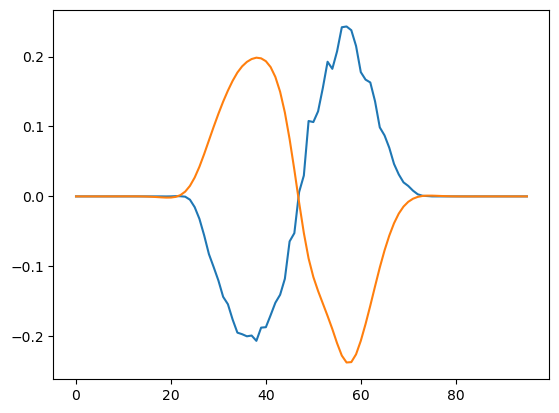

In [70]:
ix = 4
plt.plot(basis_unit[:, ix])
plt.plot(Q[:, ix])

<Axes: >

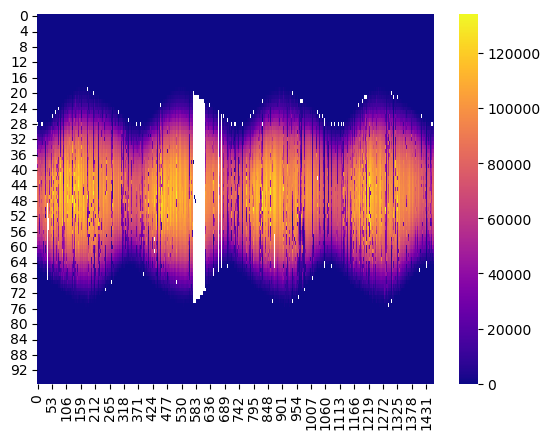

In [28]:
data = np.copy(dh.raw_data_matrix)
msk = dh.daytime_analysis.sunup_mask_estimated
data[~msk] = 0
y = data.ravel(order='F')
basis = np.tile(basis_unit, (len(y) // 96,1))
sns.heatmap(data, cmap='plasma')

In [29]:
P1 = int(365*24*4)
P2 = int(24*4)
K = 6
l = 0.1
spq = SmoothPeriodicQuantiles(K, [P1, P2], quantiles=.85, weight=l, take_log=False, verbose=True, solver='osd', custom_basis={1: basis})
spq

SmoothPeriodicQuantiles(custom_basis={1: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])},
                        num_harmonics=6, periods=[35040, 96],
                        quantiles=array([0.85]), solver='osd', verbose=True,
                        weight=0.1)

In [30]:
spq.fit(y)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
problem size:                    280617 variables
initial factorization time:      3.48e+00s
(standard algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.16e+03    1.04e+00     1.13e+00   [0.5  0.02]  1.19e-01
   25 | 3.61e+03    6.23e-02     2.78e-02   [0.5  0.02]  3.22e+00
   50 | 3.69e+03    3.41e-02     1.36e-02   [0.5  0.02]  6.47e+00
   75 | 3.71e+03    2.63e-02     7.65e-03   [0.5  0.02]  9.69e+00
  100 | 3.72e+03    1.66e-02     6.26e-03   [0.5  0.02]  1.30e+01
  125 | 3.73e+03    1.27e-02     4.63e-03  

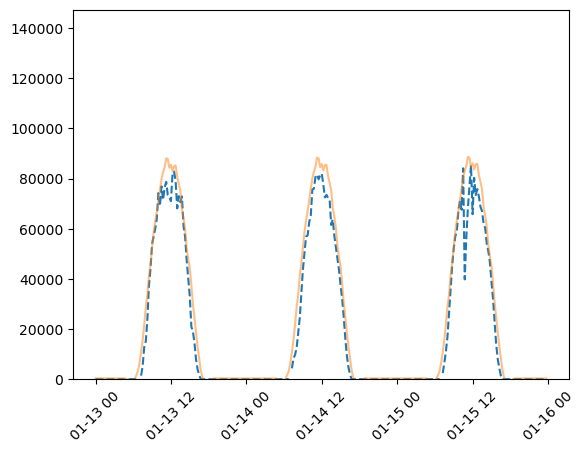

In [31]:
ix = 12
slc = np.s_[24 * 4 * ix:24 * 4 * (ix + 3)]
xs = data_frame.index[slc]
plt.plot(xs, y[slc], ls='--')
plt.plot(xs, spq.fit_quantiles[slc], alpha=0.5)
plt.ylim(-10, np.nanmax(y)*1.1)
plt.xticks(rotation=45);

/var/folders/j_/td27y9gx7rb9hpm_8cdzbzxc5b9m8z/T/ipykernel_50288/1577072111.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(xs, np.log(spq.fit_quantiles[slc]), alpha=0.5)


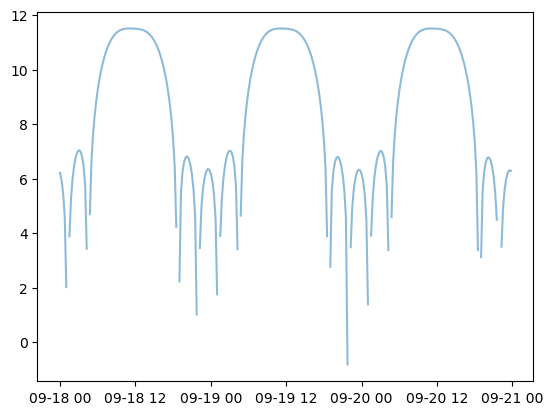

In [16]:
plt.plot(xs, np.log(spq.fit_quantiles[slc]), alpha=0.5)